In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cv2
import keras

/tmp/ipykernel_20298/570681440.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-02-16 12:56:11.084016: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-16 12:56:11.084058: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-16 12:56:11.084927: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable t

In [4]:
def IoU(box1,box2):
    
    if box1[0]<box2[0]:
        xmin, xmax = box1[0], box2[0]
        wmin, wmax = box1[2], box2[2]
    else:
        xmin, xmax = box2[0], box1[0]
        wmin, wmax = box2[2], box1[2]
        
    if box1[1]<box2[1]:
        ymin, ymax = box1[1], box2[1]
        hmin, hmax = box1[3], box2[3]
    else:
        ymin, ymax = box2[1], box1[1]
        hmin, hmax = box2[3], box1[3]
        
    if ymax-ymin>(hmin+hmax)/2 or xmax-xmin > (wmin+wmax)/2:
        intersection = 0
    else:        
        intersection = (ymin-ymax+(hmin+hmax)/2)*(xmin-xmax+(wmin+wmax)/2)
    union = wmin*hmin+wmax*hmax - intersection

    return intersection/union 

def get_best_shifts(anchor_box, boxes):
    IoUs = np.array(list(map(lambda b:IoU(b,anchor_box), boxes)))
    best_box = boxes[IoUs.argmax(axis=0)]   
    return best_box - anchor_box, IoUs.max(axis=0)

def calculate_loss():
    pass

In [24]:
num_figs = 42
max_bboxes = 16

w_list=[12,16,18]
h_list=[12,16]
scale = 16

x_data = []
bb_data = []
labels_data = []

for k in range(num_figs):
    filename = f'word_{k}'
    img = cv2.imread(f"../data/prepared/imgs/{filename}.jpg", 0)
    bboxes = pd.read_csv(f"../data/prepared/bboxes/{filename}.csv").values[:,1:].astype(int)/scale
    
    bb=[]
    lb=[]
    
    
    for i in range(0,img.shape[0],scale):
        for j in range(0,img.shape[1],scale):
            bb_shifts = []
            labels = []
            for w in w_list:
                for h in h_list:
                    box = np.array([i,j,w,h])/scale
                    shifts, mIoU = get_best_shifts(box, bboxes)
                    bb_shifts+=list(shifts)
                    # if mIoU>0.1:
                    #     print(mIoU)
                    if mIoU >=0.1:
                        mIoU =1
                    else:
                        mIoU = 0
                    labels+=[mIoU]
            lb.append(labels)
            bb.append(bb_shifts)
            
    
    x_data.append(img/255)
    bb_data.append(bb)#/([img.shape[1], img.shape[0]]*2))
    labels_data.append(lb)
    
x_data = np.array(x_data)
base_shape = (x_data.shape[0], x_data.shape[1]//scale , x_data.shape[2]//scale)
print(base_shape)
bb_data = np.array(bb_data).reshape(base_shape+(len(w_list)*len(h_list)*4 ,))
labels_data = np.array(labels_data).reshape(base_shape+(len(w_list)*len(h_list),))

x_data.shape, labels_data.shape, bb_data.shape

(42, 2, 20)


((42, 32, 320), (42, 2, 20, 6), (42, 2, 20, 24))

In [3]:
bb1 = np.reshape(bb_data, (-1, 4))
bbdf = pd.DataFrame(bb1, columns=['x', 'y', 'w', 'h']).replace(0,np.nan).dropna()
bbdf.head()

,x,y,w,h
0,7.0,7.0,15.0,18.0
1,24.0,13.0,12.0,12.0
2,37.0,13.0,14.0,12.0
3,52.0,13.0,11.0,12.0
4,80.0,13.0,11.0,12.0


In [4]:
bbdf.describe()

,x,y,w,h
count,345.000000,345.000000,345.000000,345.000000
mean,63.904348,10.605797,11.971014,12.104348
std,43.106272,2.257023,2.048617,1.941172
min,7.000000,3.000000,3.000000,3.000000
25%,30.000000,9.000000,10.000000,11.000000
50%,58.000000,11.000000,12.000000,12.000000
75%,94.000000,13.000000,13.000000,12.000000
max,194.000000,17.000000,19.000000,22.000000


[5, 0, 56, 24, 3136]


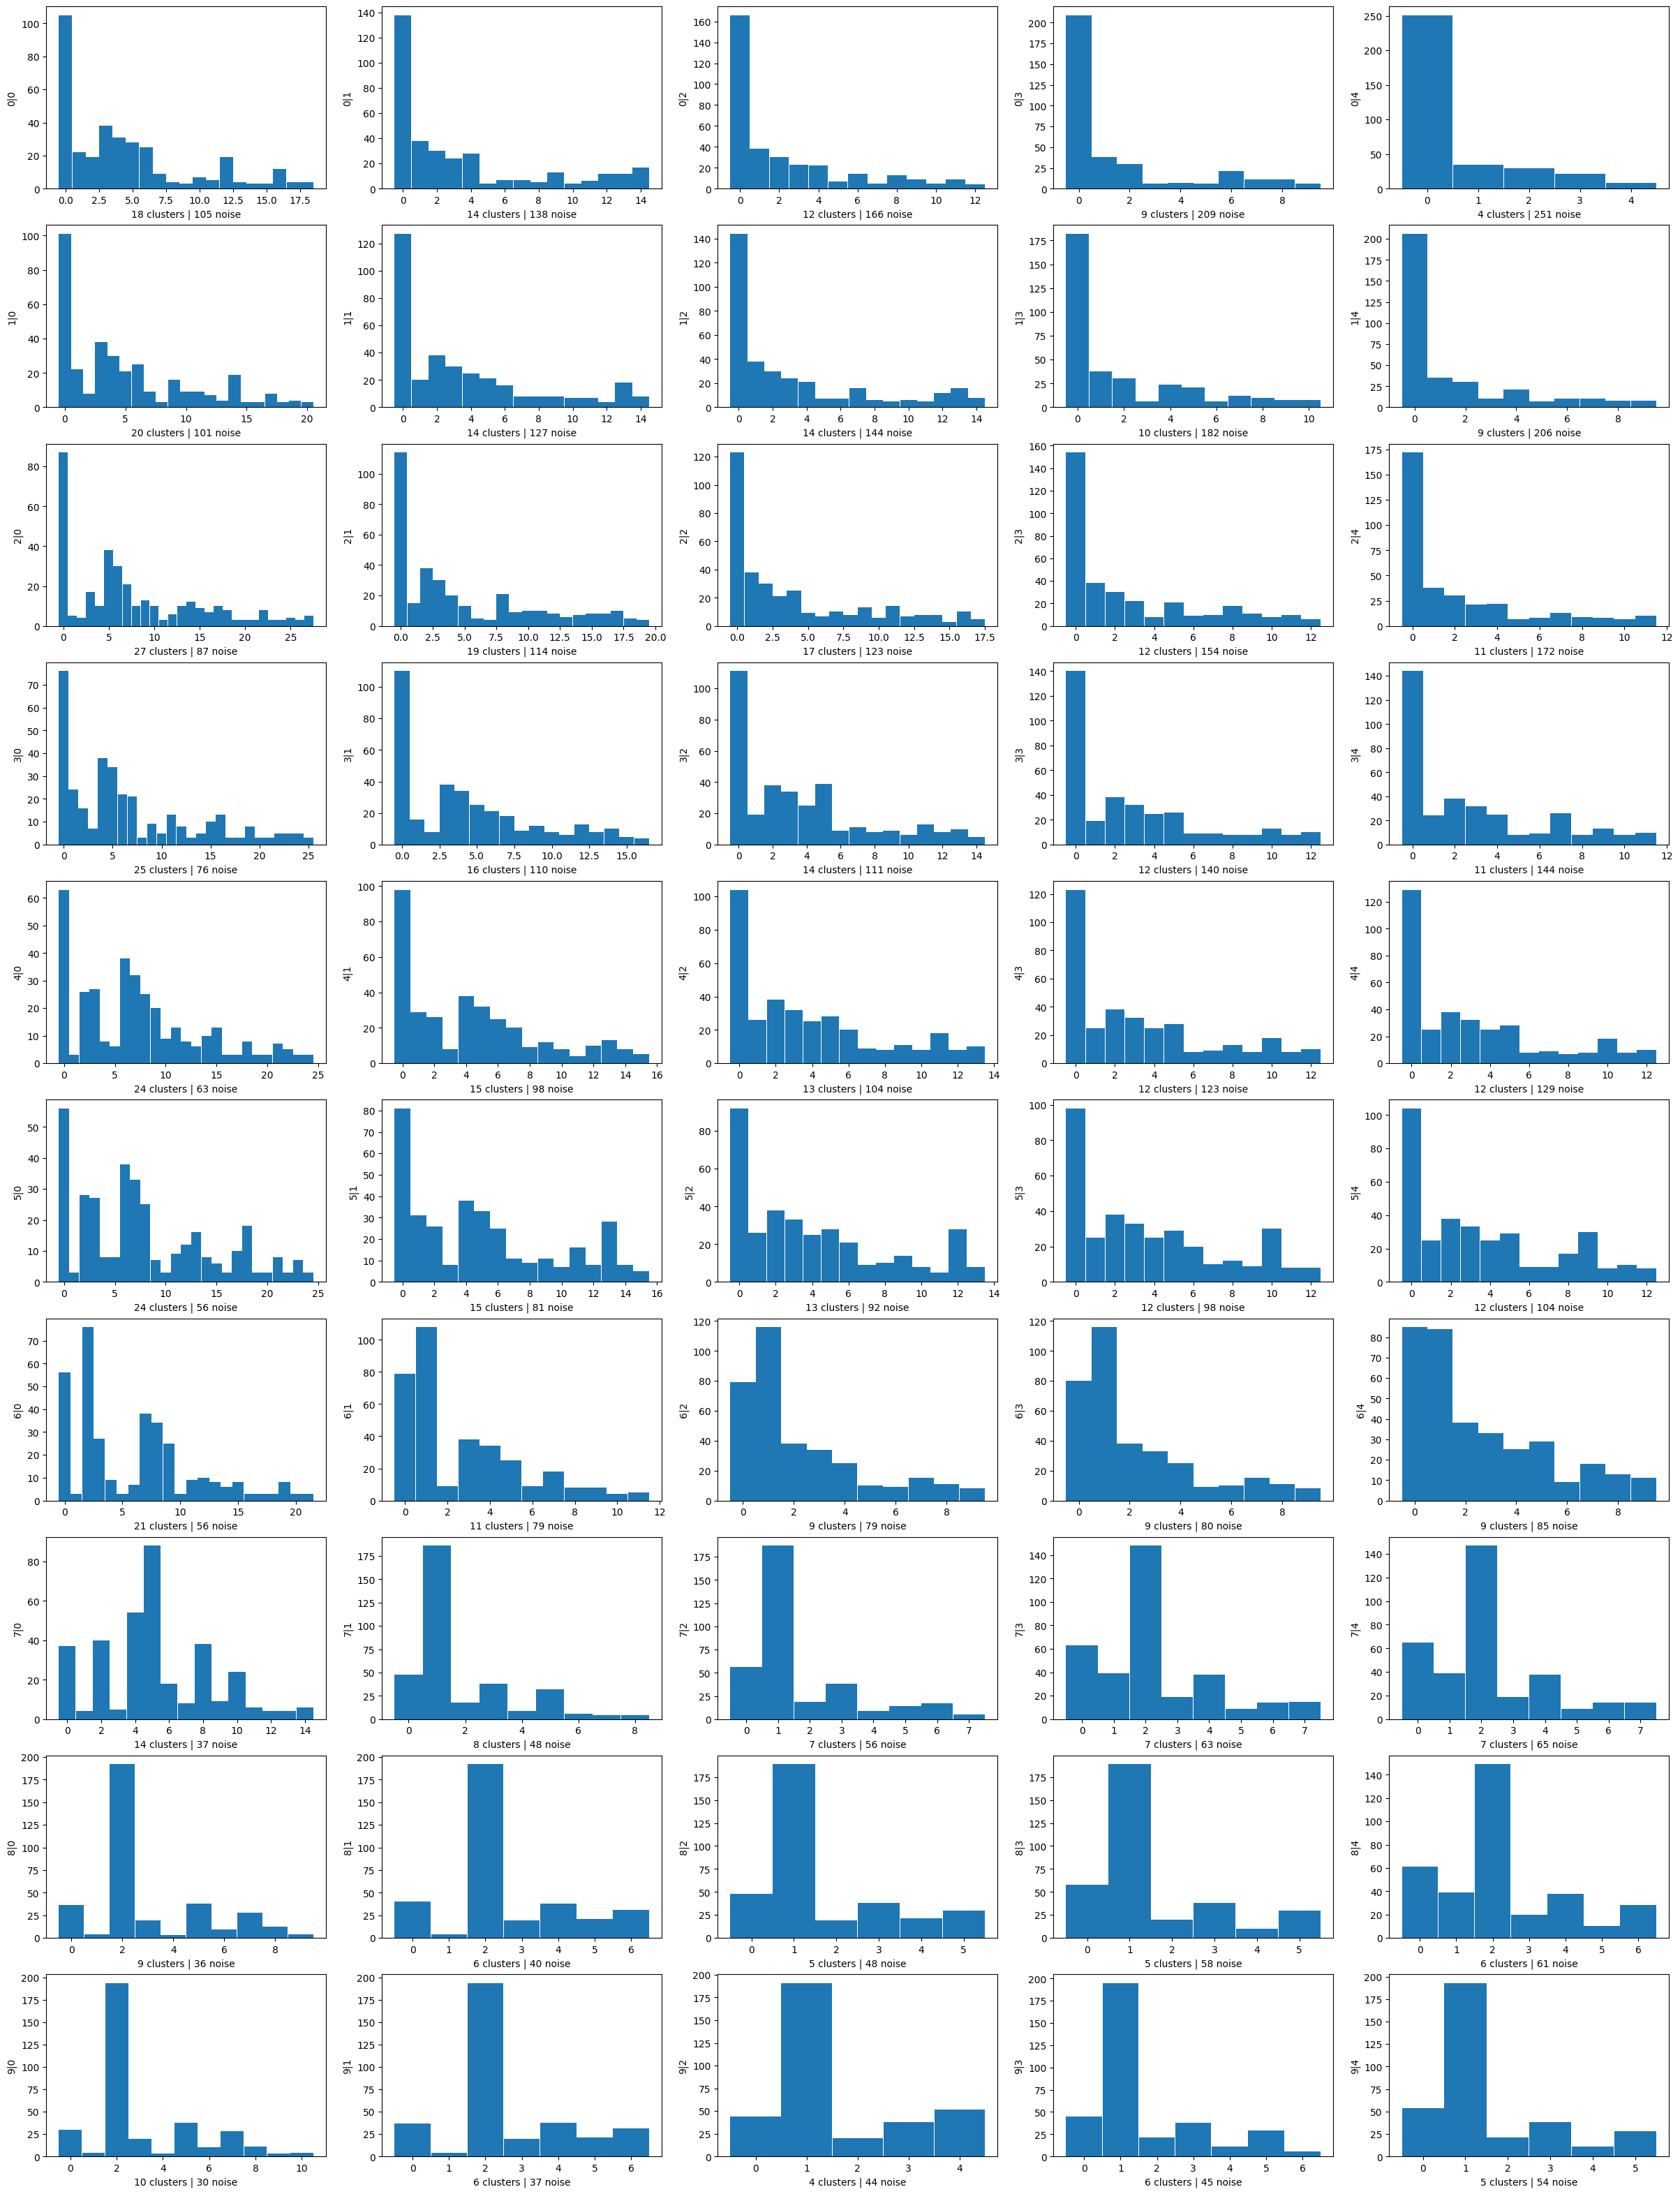

In [5]:
from sklearn.cluster import DBSCAN
x = 5
y = 10

fig,ax = plt.subplots(ncols=x, nrows=y, figsize=(30,40))

best_config = [10,1,1,1,1000000]

for eps in range(0,y):
    for ms in range(0,x):

        db = DBSCAN(eps=2+eps/4+0.5, min_samples=ms+3).fit(bbdf.values)
        labels = db.labels_
        
        # Number of clusters in labels, ignoring noise if present.
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise_ = list(labels).count(-1)
        
        
        
        
        bbdf['cluster'] = labels
        nums = bbdf.groupby('cluster').count()['x']
        
        if n_noise_*nums.values.max() < best_config[-1]:
            best_config=[eps,ms,n_noise_,n_clusters_, n_noise_*nums.values.max()]
        
        ax[eps, ms].bar(range(n_clusters_+(1 if -1 in labels else 0)), nums.values, width=0.99, align='center')
        ax[eps, ms].set(xlabel=f'{n_clusters_} clusters | {n_noise_} noise', ylabel=f'{eps}|{ms}')

print(best_config)

In [6]:
eps = 3.75
ms = 2

In [7]:
db = DBSCAN(eps=2+eps/4+0.5, min_samples=ms+3).fit(bbdf.values)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print(f'{n_clusters_} clusters | {n_noise_} noise')

bbdf['cluster'] = labels

9 clusters | 87 noise


In [8]:
bbdf.groupby('cluster').describe()

x                                                             \
        count        mean        std    min     25%    50%    75%    max   
cluster                                                                    
-1       87.0   96.206897  49.404392    7.0   55.00  106.0  137.0  194.0   
 0       50.0   75.280000   6.295577   65.0   70.00   75.5   81.0   86.0   
 1       38.0    7.000000   0.000000    7.0    7.00    7.0    7.0    7.0   
 2       36.0   20.222222   1.758426   17.0   19.00   20.5   21.0   25.0   
 3       30.0   33.066667   2.258063   29.0   31.25   33.0   34.0   39.0   
 4       59.0   51.813559   6.503247   41.0   46.00   54.0   57.0   62.0   
 5        9.0  131.222222   0.666667  130.0  131.00  131.0  132.0  132.0   
 6       19.0   93.421053   1.835326   90.0   92.00   94.0   94.0   97.0   
 7        7.0  104.714286   2.214670  102.0  103.00  105.0  106.0  108.0   
 8       10.0  118.100000   2.024846  116.0  116.00  118.0  120.0  121.0   

            y             ...     w           h                             \
        count       mean  ...   75%   max count       mean       std   min   
cluster                   ...                                                
-1       87.0  10.080460  ...  15.5  19.0  87.0  12.885057  3.096980   3.0   
 0       50.0  10.480000  ...  13.0  16.0  50.0  11.800000  1.087968  11.0   
 1       38.0  10.868421  ...  13.0  14.0  38.0  11.736842  1.329178  11.0   
 2       36.0  10.527778  ...  12.0  13.0  36.0  12.277778  1.542004  11.0   
 3       30.0  10.766667  ...  13.0  14.0  30.0  11.833333  0.746640  11.0   
 4       59.0  10.796610  ...  13.0  16.0  59.0  12.050847  1.591180  11.0   
 5        9.0  11.555556  ...  13.0  15.0   9.0  11.222222  0.440959  11.0   
 6       19.0  10.684211  ...  13.0  14.0  19.0  11.473684  0.512989  11.0   
 7        7.0  12.285714  ...  12.5  13.0   7.0  11.285714  0.487950  11.0   
 8       10.0  11.300000  ...  13.0  13.0  10.0  11.300000  0.483046  11.0   

                                   
           25%   50%    75%   max  
cluster                            
-1       11.00  12.0  15.00  22.0  
 0       11.00  12.0  12.00  16.0  
 1       11.00  11.0  12.00  16.0  
 2       11.75  12.0  12.00  17.0  
 3       11.25  12.0  12.00  15.0  
 4       11.00  11.0  12.00  16.0  
 5       11.00  11.0  11.00  12.0  
 6       11.00  11.0  12.00  12.0  
 7       11.00  11.0  11.50  12.0  
 8       11.00  11.0  11.75  12.0  

[10 rows x 32 columns]

In [9]:
anchor_boxes = []
for i in range(n_clusters_):
    anchor_boxes.append(bbdf[bbdf['cluster']==i].mean().values[:-1])
anchor_boxes = np.array(anchor_boxes)
anchor_boxes.shape

(9, 4)

In [10]:
extras = bbdf[bbdf['cluster']==-1].drop('cluster', axis=1).values
extras.shape

(87, 4)

In [11]:
anchor_boxes = np.vstack([anchor_boxes, extras]).tolist()
anchor_boxes.sort(key = lambda bb: bb[0])
anchor_boxes = np.array(anchor_boxes)
anchor_boxes.shape

(96, 4)

In [12]:
def IoU(box1,box2):
    
    if box1[0]<box2[0]:
        xmin, xmax = box1[0], box2[0]
        wmin, wmax = box1[2], box2[2]
    else:
        xmin, xmax = box2[0], box1[0]
        wmin, wmax = box2[2], box1[2]
        
    if box1[1]<box2[1]:
        ymin, ymax = box1[1], box2[1]
        hmin, hmax = box1[3], box2[3]
    else:
        ymin, ymax = box2[1], box1[1]
        hmin, hmax = box2[3], box1[3]
        
    if ymax-ymin>(hmin+hmax)/2 or xmax-xmin > (wmin+wmax)/2:
        intersection = 0
    else:        
        intersection = (ymin-ymax+(hmin+hmax)/2)*(xmin-xmax+(wmin+wmax)/2)
    union = wmin*hmin+wmax*hmax - intersection

    return intersection/union 

def get_best_shifts(anchor_box, boxes):
    IoUs = np.array(list(map(lambda b:IoU(b,anchor_box), boxes)))
    best_box = boxes[IoUs.argmax(axis=0)]   
    return best_box - anchor_box

get_best_shifts(anchor_boxes[0], bb_data[0])

array([ 0.        , -3.86842105,  3.13157895,  6.26315789])

In [13]:
ab_df = pd.DataFrame(anchor_boxes)

In [14]:
ab_df.to_csv('../data/prepared/bboxes/ab.csv')

In [15]:
y_data = []
for i in range(num_figs):
    filename = f'word_{i}'
    bboxes = pd.read_csv(f"../data/prepared/bboxes/{filename}.csv").values[:,1:].astype(int).tolist()
    Y = []
    for abox in anchor_boxes:
        Y.append(get_best_shifts(abox,bboxes))
    y_data.append(Y)
y_data = np.array(y_data)
y_data.shape

(42, 96, 4)

In [16]:
x_data.shape

(42, 32, 320)

In [17]:
import keras

In [24]:
inputs = keras.Input(shape=(x_data.shape[1:]))
x = keras.layers.Reshape(x_data.shape[1:]+(1,))(inputs)
x = keras.layers.Concatenate(axis=-1)([x,x,x])
# x = keras.layers.Conv2D(3, (1, 1), activation='linear', name='R')(x)


backbone = keras.applications.VGG16(include_top=False, input_tensor=x, weights='imagenet')
backbone.trainable = False

region_proposal = keras.layers.Conv2D(256, (3,3), activation='relu', padding='same', name='RPN_input')(backbone.layers[-2].output)
region_proposal = keras.layers.Conv2D(4,(1,1), activation='relu', padding='same', name='RPN_reg')(region_proposal)
region_proposal = keras.layers.Flatten()(region_proposal)

neck = keras.layers.Flatten()(backbone.layers[-2].output)
neck = keras.layers.Dense(1024, activation='relu')(neck)
neck = keras.layers.Concatenate(axis=-1)([neck,region_proposal])

head = keras.layers.Dense(y_data.shape[1]*y_data.shape[2], activation='tanh')(neck)
head = keras.layers.Reshape((y_data.shape[1],y_data.shape[2]))(head)

model = keras.Model(inputs=inputs, outputs=head)
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃ Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 32, 320)   │       0 │ -                    │
│ (InputLayer)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ reshape_5 (Reshape) │ (None, 32, 320,   │       0 │ input_layer_3[0][0]  │
│                     │ 1)                │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ concatenate_5       │ (None, 32, 320,   │       0 │ reshape_5[0][0],     │
│ (Concatenate)       │ 3)                │         │ reshape_5[0][0],     │
│                     │                   │         │ reshape_5[0][0]      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ block1_conv1        │ (None, 32, 320,   │   1,792 │ concatenate_5[0][0]  │
│ (Conv2D)            │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ block1_conv2        │ (None, 32, 320,   │  36,928 │ block1_conv1[0][0]   │
│ (Conv2D)            │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ block1_pool         │ (None, 16, 160,   │       0 │ block1_conv2[0][0]   │
│ (MaxPooling2D)      │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ block2_conv1        │ (None, 16, 160,   │  73,856 │ block1_pool[0][0]    │
│ (Conv2D)            │ 128)              │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ block2_conv2        │ (None, 16, 160,   │ 147,584 │ block2_conv1[0][0]   │
│ (Conv2D)            │ 128)              │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ block2_pool         │ (None, 8, 80,     │       0 │ block2_conv2[0][0]   │
│ (MaxPooling2D)      │ 128)              │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ block3_conv1        │ (None, 8, 80,     │ 295,168 │ block2_pool[0][0]    │
│ (Conv2D)            │ 256)              │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ block3_conv2        │ (None, 8, 80,     │ 590,080 │ block3_conv1[0][0]   │
│ (Conv2D)            │ 256)              │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ block3_conv3        │ (None, 8, 80,     │ 590,080 │ block3_conv2[0][0]   │
│ (Conv2D)            │ 256)              │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ block3_pool         │ (None, 4, 40,     │       0 │ block3_conv3[0][0]   │
│ (MaxPooling2D)      │ 256)              │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ block4_conv1        │ (None, 4, 40,     │ 1,180,… │ block3_pool[0][0]    │
│ (Conv2D)            │ 512)              │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ block4_conv2        │ (None, 4, 40,     │ 2,359,… │ block4_conv1[0][0]   │
│ (Conv2D)            │ 512)              │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ block4_conv3        │ (None, 4, 40,     │ 2,359,… │ block4_conv2[0][0]   │
│ (Conv2D)            │ 512)              │         │                      │
├─────────────────────┼───────────────────┼─────────┼────────────────────

 Total params: 37,323,204 (142.38 MB)

 Trainable params: 22,608,516 (86.24 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

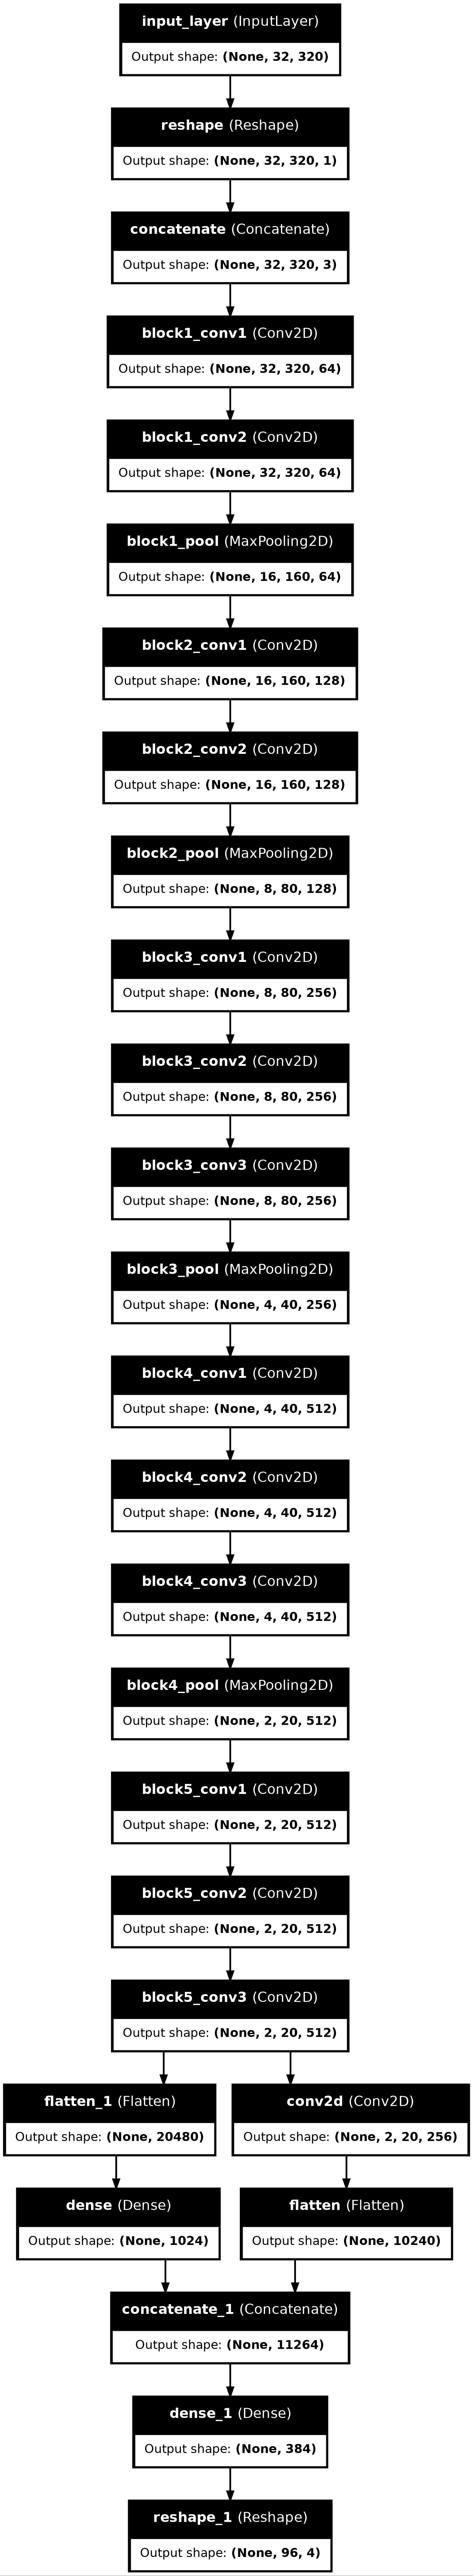

In [19]:
keras.utils.plot_model(model, to_file='model.jpg', show_shapes=True, show_layer_names=True)

In [20]:
model.compile(optimizer='adam', loss='mse')

In [21]:
his = model.fit(x_data, y_data,
          shuffle=True,
          # validation_split=0.2,
          # batch_size=4,
          epochs=1000)

Epoch 1/1000


2024-02-16 10:39:46.017903: I external/local_xla/xla/service/service.cc:168] XLA service 0xaf53f40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-16 10:39:46.017965: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2024-02-16 10:39:46.068250: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-16 10:39:46.278980: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-02-16 10:39:49.234509: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 8.79GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-02-16 10:39:49.234558: W exter

1/2 ━━━━━━━━━━━━━━━━━━━━ 6s 7s/step - loss: 1552.1580

I0000 00:00:1708069191.349948    5096 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - loss: 1601.9523
Epoch 2/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1554.1157
Epoch 3/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1564.7550
Epoch 4/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1585.5055
Epoch 5/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1566.4912
Epoch 6/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1532.4305
Epoch 7/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1554.7899
Epoch 8/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1556.6560
Epoch 9/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1603.1844
Epoch 10/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1553.1112
Epoch 11/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1637.5082
Epoch 12/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1581.0864
Epoch 13/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1609.6763
Epoch 14/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1596.3170
Epoch 15/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16


KeyboardInterrupt



In [ ]:
plt.plot(his.history['loss'])